In [221]:
import sframe                                                  # see below for install instruction
import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

%matplotlib inline

In [222]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [223]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

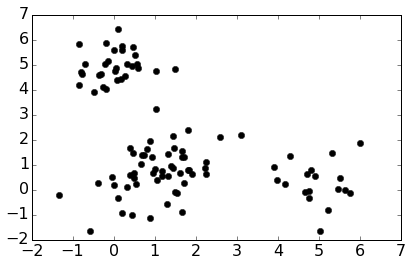

In [224]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [225]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [244]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    #print len(means)
    covariances = init_covariances[:]
    #print covariances
    weights = init_weights[:]
    #print weights
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        
        for j in range(num_data):
            for k in range(num_clusters):
                # YOUR CODE HERE
                #pi_hat=weights[k]/float(num_data)
                resp[j, k] = weights[k]*multivariate_normal.pdf(data[j], means[k], covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        
        resp = resp / row_sums # normalize over all possible cluster assignments
        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0) #column wise count rk
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            #print counts[k]
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += (resp[j,k] * data[j])
            # YOUR CODE HERE
            means[k] = (weighted_sum/counts[k])
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
        

            
            for j in range(num_data):
                # YOUR CODE HERE (Hint: Use np.outer on the data[j] and this cluster's mean)
                mat1=np.array(data[j]-means[k])
                mat1=mat1.reshape(mat1.shape[0],1)
                #print mat1.shape
                
                mat2=mat1.T
                
                #print mat2.shape
                toadd=np.outer(mat1,mat2) * resp[j,k]
                #print toadd  * resp(k,j)
                weighted_sum += toadd
            # YOUR CODE HERE
            covariances[k] =weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [245]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [246]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

/Library/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


Iteration 0
Iteration 5
Iteration 10
Iteration 11
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


/Library/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


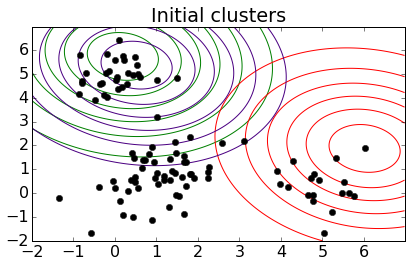

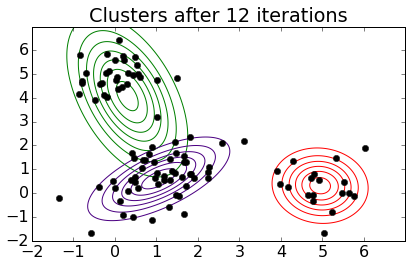

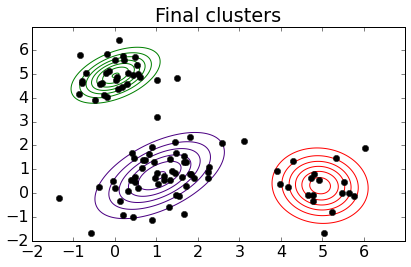

In [248]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# Parameters after 12 iterations
results = EM(data, initial_means, initial_covs, initial_weights, maxiter=12) # YOUR CODE HERE
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


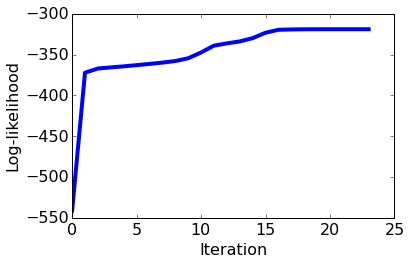

In [251]:
results = EM(data, initial_means, initial_covs, initial_weights)
# YOUR CODE HERE
loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [358]:
images = sframe.SFrame('images.sf/')
images['rgb'] = images.pack_columns(['red', 'green', 'blue'])['X4']

In [359]:
print images

+-------------------------------+------------------------+---------+
|              path             |         image          |  folder |
+-------------------------------+------------------------+---------+
| /data/coursera/images/suns... | Height: 194 Width: 259 | sunsets |
| /data/coursera/images/suns... | Height: 194 Width: 259 | sunsets |
| /data/coursera/images/suns... | Height: 183 Width: 275 | sunsets |
| /data/coursera/images/suns... | Height: 183 Width: 276 | sunsets |
| /data/coursera/images/suns... | Height: 177 Width: 284 | sunsets |
| /data/coursera/images/suns... | Height: 177 Width: 284 | sunsets |
| /data/coursera/images/suns... | Height: 194 Width: 259 | sunsets |
| /data/coursera/images/suns... | Height: 183 Width: 275 | sunsets |
| /data/coursera/images/suns... | Height: 275 Width: 183 | sunsets |
| /data/coursera/images/suns... | Height: 183 Width: 275 | sunsets |
+-------------------------------+------------------------+---------+
+----------------+----------------

In [255]:
#Initialization. We need to come up with initial estimates for the mixture weights and component parameters. 
#Let's take three images to be our initial cluster centers, and 
#let's initialize the covariance matrix of each cluster to be diagonal with each element 
#equal to the sample variance from the full data. As in our test on simulated data, 
#we'll start by assuming each mixture component has equal weight.

np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 118


In [360]:
print out

{'loglik': [1827.1639483578147, 3157.1381024873049, 3255.1934750674236, 3316.7841055086051, 3356.4420984087706, 3381.432937097396, 3397.0409326659005, 3408.4225803243376, 3418.2303790488772, 3426.9869925473208, 3434.1040944337446, 3440.2161112066765, 3445.6469733156978, 3450.5226265408587, 3454.8605469731388, 3458.5686389540065, 3461.5545686420751, 3463.8299135431239, 3465.4924781289851, 3466.6651345439845, 3467.4693959150295], 'resp': array([[  1.51008212e-09,   2.01550551e-10,   1.51474517e-02,
          9.84852547e-01],
       [  1.06899392e-20,   1.87813078e-15,   3.84655288e-12,
          1.00000000e+00],
       [  1.46960314e-30,   1.14781832e-43,   4.90804457e-16,
          1.00000000e+00],
       ..., 
       [  1.78808146e-31,   4.86706002e-03,   9.45799471e-01,
          4.93334685e-02],
       [  4.01759909e-30,   6.10098078e-02,   8.81877260e-01,
          5.71129321e-02],
       [  2.42770374e-05,   8.09138791e-01,   5.01666436e-02,
          1.40670289e-01]]), 'covs': [ar

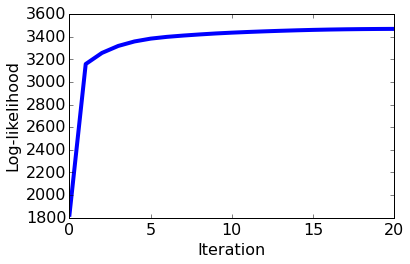

In [361]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

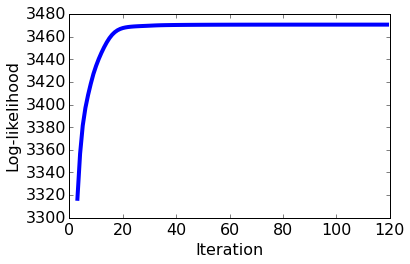

In [258]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [259]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

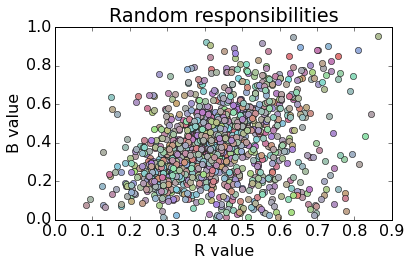

In [260]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')

Iteration 0


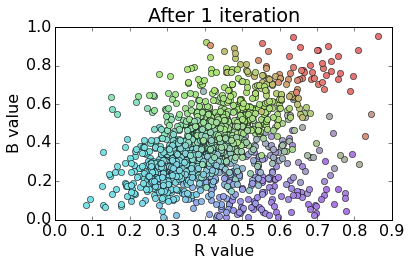

In [264]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out['resp'], 'After 1 iteration')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


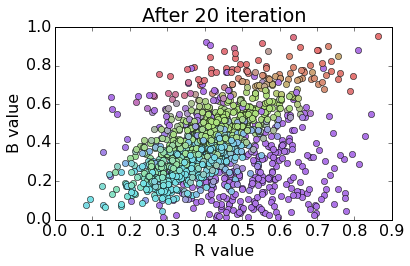

In [265]:
#Clusters are not well seperated still due to the fact we decided to do it in 2D space instead of 3D space
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out['resp'], 'After 20 iteration')

In [362]:
#Calculate the likelihood (score) of the first image in our data set (images[0])
#under each Gaussian component through a call to multivariate_normal.pdf. 
#Given these values, what cluster assignment should we make for this image?

means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images)
K = len(means)

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        # YOUR CODE HERE (Hint: use multivariate_normal.pdf and rgb[i])
        p[k] = multivariate_normal.pdf(rgb[i],means[k],covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    # YOUR CODE HERE
    #print np.argmax(p)
    #print len(p)
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    # YOUR CODE HERE
    probs[i] = p[np.argmax(p)]

assignments = sframe.SFrame({'assignments':assignments, 'probs':probs, 'image': images['image']})

In [363]:
print assignments

+-------------+------------------+------------------------+
| assignments |      probs       |         image          |
+-------------+------------------+------------------------+
|      3      |  16.5271595911   | Height: 194 Width: 259 |
|      3      |  8.08362978275   | Height: 194 Width: 259 |
|      3      |  2.89751022995   | Height: 183 Width: 275 |
|      3      | 0.00571564051932 | Height: 183 Width: 276 |
|      3      |  10.9352260395   | Height: 177 Width: 284 |
|      3      |  25.2614963611   | Height: 177 Width: 284 |
|      3      |  8.86657966748   | Height: 194 Width: 259 |
|      3      |  10.2395807105   | Height: 183 Width: 275 |
|      3      |  11.6378582377   | Height: 275 Width: 183 |
|      2      |  68.5294981075   | Height: 183 Width: 275 |
+-------------+------------------+------------------------+
[1328 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [333]:
print images

[]


In [364]:
#(HINT: use the SFrame function topk(column, k) 
#to find the k top values according to specified column in an SFrame).
def get_top_images(assignments, cluster, k=5):
    # YOUR CODE HERE
    images_in_cluster = assignments[assignments['assignments']==cluster]
    top_images = images_in_cluster.topk('probs', k)
    return top_images['image']

In [370]:

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
def display_images(images):
    from IPython.display import display
    
    for image in images:
        img=display(Image.open(BytesIO(image._image_data)))
        a=np.array(img.getdata()).astype(np.float32).reshape( (img.size[0],img.size[1],3) )
        new_img = Image.fromarray( a, mode='RGB' )
        new_img.show()

In [372]:
def save_images(images, prefix):
    for i, image in enumerate(images):
        Image.open(BytesIO(image._image_data)).save(prefix % i)

In [336]:
check=assignments[assignments['assignments']==1]
print check.topk('probs',10)
#print check

+-------------+---------------+------------------------+
| assignments |     probs     |         image          |
+-------------+---------------+------------------------+
|      1      | 421.551710901 | Height: 156 Width: 324 |
|      1      | 413.432135849 | Height: 194 Width: 259 |
|      1      |  405.0936897  | Height: 183 Width: 275 |
|      1      | 404.510097281 | Height: 160 Width: 315 |
|      1      | 400.914842018 | Height: 168 Width: 300 |
|      1      |  399.85120606 | Height: 140 Width: 188 |
|      1      | 396.821796926 | Height: 194 Width: 259 |
|      1      | 387.573030559 | Height: 181 Width: 278 |
|      1      |  387.56655915 | Height: 183 Width: 275 |
|      1      | 381.765109839 | Height: 159 Width: 318 |
+-------------+---------------+------------------------+
[10 rows x 3 columns]



In [339]:
from IPython.display import display

In [373]:
from io import BytesIO
for component_id in range(4):
    print 'Component {0:d}'.format(component_id)
    images = get_top_images(assignments, component_id)
    print images
    #display_images(images)
    save_images(images, 'component_{0:d}_%d.jpg'.format(component_id))
    print '\n'

Component 0
['Height: 183 Width: 275', 'Height: 194 Width: 259', 'Height: 184 Width: 274', 'Height: 177 Width: 284', 'Height: 194 Width: 259']


Component 1
['Height: 156 Width: 324', 'Height: 194 Width: 259', 'Height: 183 Width: 275', 'Height: 160 Width: 315', 'Height: 168 Width: 300']


Component 2
['Height: 152 Width: 270', 'Height: 270 Width: 186', 'Height: 168 Width: 300', 'Height: 183 Width: 275', 'Height: 174 Width: 290']


Component 3
['Height: 177 Width: 284', 'Height: 194 Width: 259', 'Height: 183 Width: 275', 'Height: 183 Width: 275', 'Height: 182 Width: 276']


